## Fichier dédié à l'établissement du modèle de régression RandomForest

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import qsar_utils as qu

### Lecture des données

In [2]:
df_norm = pd.read_csv("data/qsar_fish_toxicity_norm.csv")
df_raw = pd.read_csv("data/qsar_fish_toxicity.csv")

### Initialisation des données

In [76]:
train_data, test_data = train_test_split(df_norm, train_size=0.7)
LC50_train = train_data["LC50"]
LC50_test = test_data["LC50"]
train_data = train_data.drop(columns="LC50")
test_data = test_data.drop(columns="LC50")

In [4]:
train_data_raw, test_data_raw = train_test_split(df_raw, train_size=0.7)
LC50_train_raw = train_data_raw["LC50"]
LC50_test_raw = test_data_raw["LC50"]
train_data_raw = train_data_raw.drop(columns="LC50")
test_data_raw = test_data_raw.drop(columns="LC50")

### Création du modèle brut

In [77]:
model = RandomForestRegressor()
model.fit(train_data, LC50_train)
prediction = model.predict(test_data)
corr_coeff, _ = pearsonr(prediction, LC50_test)
print(pearsonr(prediction, LC50_test))

PearsonRResult(statistic=0.8146316621411291, pvalue=4.549338428002482e-66)


In [6]:
model_raw = RandomForestRegressor()
model_raw.fit(train_data_raw, LC50_train_raw)
prediction_raw = model.predict(test_data_raw)
corr_coeff_raw, _ = pearsonr(prediction_raw, LC50_test_raw)
print(pearsonr(prediction_raw, LC50_test_raw))

PearsonRResult(statistic=0.4055590954092725, pvalue=3.1227962875706745e-12)


### Visualisation du résultat

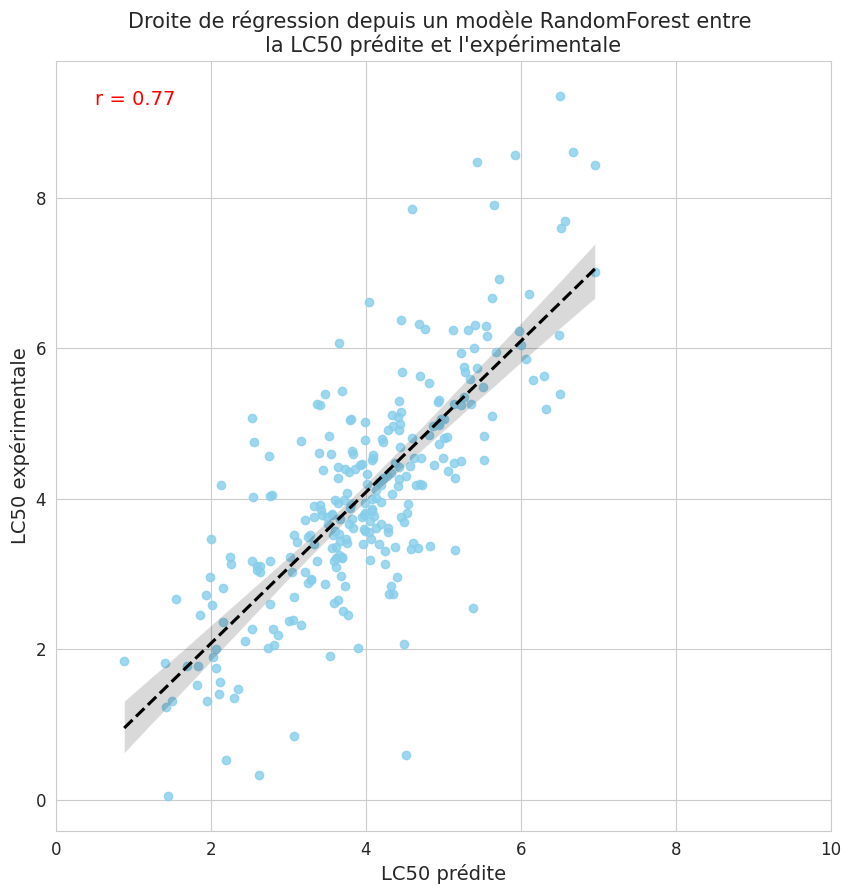

In [7]:
qu.scatter_QSAR(prediction, LC50_test, corr_coeff, model_type="RandomForest")

### Visualisation des résultats (données brutes)

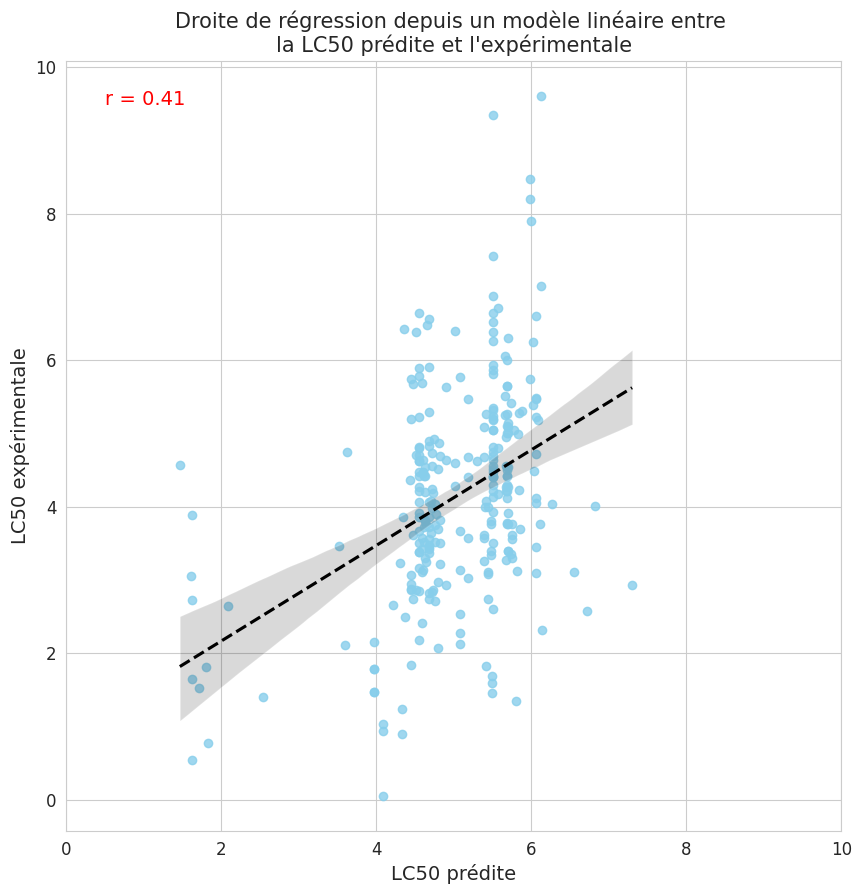

In [8]:
qu.scatter_QSAR(prediction_raw, LC50_test_raw, corr_coeff_raw)

Ca prouve que la normalisation est bien efficace dans les algo de ML un peu plus élaboré que la régression linéaire

## Optimisation des hyperparamètres

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV

# Chargement des données
df_norm = pd.read_csv("data/qsar_fish_toxicity_norm.csv")
X = df_norm.drop(columns=["LC50"])
y = df_norm["LC50"]

# Grille d'hyperparamètres
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5]
}

# Définir la validation croisée interne et externe
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Modèle
rf = RandomForestRegressor(random_state=42)

# Préparer le GridSearchCV (ce sera réutilisé à chaque fold externe)
search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=inner_cv,  # la CV interne pour le tuning
    n_jobs=-1
)

# Liste pour stocker les scores
outer_scores = []
# Liste pour stocker les hyperparamètres
outer_best_params = []

# Boucle de la validation croisée externe
for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # GridSearchCV sur le fold externe courant (CV interne)
    search.fit(X_train, y_train)
    
    # Récupérer les meilleurs hyperparamètres
    best_params = search.best_params_
    outer_best_params.append(best_params)
    
    # Évaluer sur le test du fold externe
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = np.mean((y_test - y_pred)**2)
    outer_scores.append(mse)

# Afficher la moyenne des MSE sur les folds externes
print("MSE moyen :", np.mean(outer_scores))

# Afficher les hyperparamètres choisis à chaque split
for i, bp in enumerate(outer_best_params):
    print(f"Fold {i+1}: {bp}")


MSE moyen : 0.8130161875131258
Fold 1: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Fold 2: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Fold 3: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Fold 4: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Fold 5: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


### Même chose mais avec des paramètres dans une certaine plage

In [42]:
import numpy as np
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform

param_distributions = {
    'n_estimators': randint(50, 300),
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': uniform(0.1, 0.9)
}

outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

rf = RandomForestRegressor(random_state=42)

scores = []
outer_best_params = []

# Boucle externe
for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # RandomizedSearchCV avec la CV interne
    search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_distributions,
        n_iter=50,
        scoring="neg_mean_squared_error",
        cv=inner_cv,
        random_state=42,
        n_jobs=-1
    )
    # Fit sur le fold actuel (portion train)
    search.fit(X_train, y_train)
    
    # Récupération des meilleurs hyperparamètres
    best_params = search.best_params_
    outer_best_params.append(best_params)
    
    # Évaluation sur la portion test
    y_pred = search.best_estimator_.predict(X_test)
    mse = np.mean((y_test - y_pred)**2)
    scores.append(mse)

print("MSE moyen sur la boucle externe :", np.mean(scores))
print("Hyperparamètres choisis par fold :", outer_best_params)


MSE moyen sur la boucle externe : 0.9789011195700148
Hyperparamètres choisis par fold : [{'max_depth': 10, 'min_samples_split': 0.1363902305845882, 'n_estimators': 256}, {'max_depth': 10, 'min_samples_split': 0.1363902305845882, 'n_estimators': 256}, {'max_depth': 10, 'min_samples_split': 0.1363902305845882, 'n_estimators': 256}, {'max_depth': 10, 'min_samples_split': 0.1363902305845882, 'n_estimators': 256}, {'max_depth': 10, 'min_samples_split': 0.1363902305845882, 'n_estimators': 256}]
